# Replicating the Analysis


**Data Preparation**

In [27]:
%run functions.py

We use the Compas-scores-two-years dataset published by ProPublica and apply the same data filter used by them to create a new dataframe compas_df. The dataset contains information on defendants charged with a crime and assessed using the COMPAS risk assessment tool. The data includes demographic information, criminal history, and the results of the COMPAS assessment, including a predicted risk score and likelihood of recidivism over a two-year period. The filter selects only the rows from the data where the number of days between the arrest and the screening is within the range of -30 to 30, the value in the is_recid column is not -1, the value in the c_charge_degree column is not "O", and the value in the score_text column is not "N/A".

In [35]:
# load compas data
compas_df = load_compas_df()
compas_df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [37]:
# load COX data
parsed_dataURL = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/cox-parsed.csv'
parsed_data = load_cox_data()

## ProPublica analysis

ProPublica in their article claims that the COMPAS algorithm is biased agains black people. They based their argument on the following:
- The distributions of decile scores is different in each of the groups, where white people are assigned more low scores whereas for African-Americans the distribution is more balanced.
- Black people are more likely to be assigned a high score.
- White people were more often wrongly assigned low scores than blacks.

*Next*, we will reproduce some of the claims.

### Compas Score Distribution

In [10]:
df = compas_df.copy()

In [11]:
# Create a dataframe with only the african-americans and caucasians
df_binary = df.loc[df['race'].isin(["African-American","Caucasian"])]

In [12]:
# Calculate the total and proportions of decile scores per race
decile_score_by_race_prop= df_binary.groupby(['race', 'decile_score']).agg({'decile_score': 'count'})
decile_score_by_race_prop['prop'] = decile_score_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

In [13]:
# Calculate the total and proportions of recidivates per race
is_recid_by_race_prop= df_binary.groupby(['race', 'is_recid']).agg({'decile_score': 'count'})
is_recid_by_race_prop['prop'] = is_recid_by_race_prop.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))

Text(0, 0.5, 'Count')

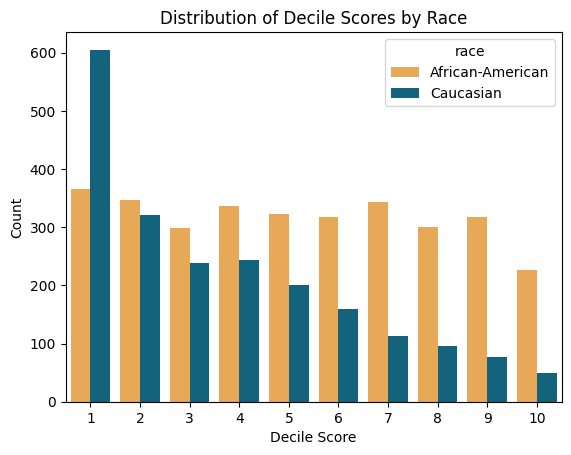

In [14]:
sns.countplot(
    data = df_binary,
    x = 'decile_score',
    hue = 'race',
    palette = ["#ffab40","#016d8c"]
)
plt.title('Distribution of Decile Scores by Race')
plt.xlabel('Decile Score')
plt.ylabel('Count')

In this plot we can see that Caucasians's distribution of scores is skewed towards lower scores, whereas African Americans have a similar numbers for each of the scores.

### Most predictive factors in logistic model (with controlling for other factors) for score


In [16]:
# As in the ProPublica article the score text "medium" and "high" are labeled "high", the score text "low" stays the same in order to have binary score texts
df['score_text_binary'] = df['score_text'].replace(['Medium'], 'High')

In [17]:
# In order to be able to use this labeling in the regression, the labels need to be numerical
df['score_text_binary']= df['score_text_binary'].replace(['High'], 1)
df['score_text_binary']= df['score_text_binary'].replace(['Low'], 0)

ProPublica claims that Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior (when adjusted for other variables).

For that, we reproduced the logistic regression they made, and later we adjust it.

In [18]:
# Logistic Regression: Where the intercept doesn't take the right value automatically, we set it via the reference. 
# The Intercept shall be: white, male, aged between 25-45
import statsmodels.formula.api as smf

est = smf.logit('score_text_binary ~ C(age_cat) + C(race, Treatment(reference="Caucasian")) + C(sex,Treatment(reference="Male")) + priors_count + C(c_charge_degree) + two_year_recid', df).fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      score_text_binary   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Mon, 13 Feb 2023   Pseudo R-squ.:                  0.2729
Time:                        21:38:45   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Interc

In [19]:
# Controlling for other variables by taking the Intercept to have a control and a treatment group
ControlgGroup= np.exp(-1.5255)/(1+ np.exp(-1.5255))
FinalClaim= np.exp(0.4772)/(1- ControlgGroup + (ControlgGroup * np.exp(0.4772)))
FinalClaim
# Interpretation: Black people are 45% more likely to be assesed as high risk

1.452825407001621

The FinalClaim 1.45 indicates that Black people are 45% more likely to be assesed as high risk

## Northpointe's Rebuttal Analysis

### Different base rates for recidivism

Northpointe, in their rebuttal to the ProPublica article, explain that:
- Propublica failed to include information about the data they used. White people got lower values because they have lower imputs of the risk scales, such as less drug problems, less criminal history, older age than for the black people sample. In addition, white people have lower base rates for recidivism.
- COMPAS has equal discriminative ability (equally accurate) for blacks and whites because the AUC for white and black defendant are not significally different. 
- ProPublica confuses model errors with population error. To test racial bias, Northpointes argues that the population errors should be analyzed, and not the model errors as ProPublica did. They explain that the false positive rate (meaning assign someone as high risk when they are not) will increase if the base rate increases (high recidivism rates for black people). 


Text(0, 0.5, 'Count')

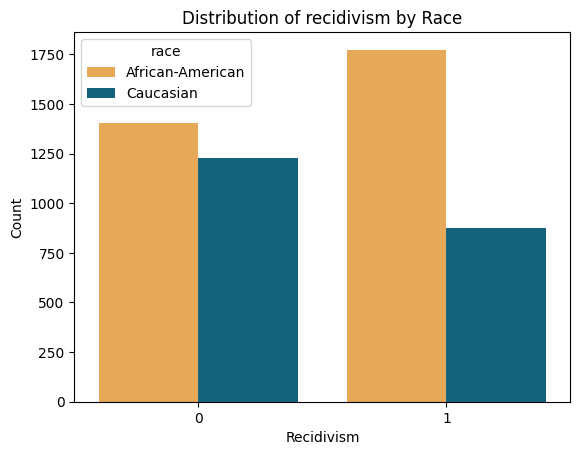

In [20]:
sns.countplot(
    data = df_binary,
    x = 'is_recid',
    hue = 'race',
    palette = ["#ffab40","#016d8c"]
)
plt.title('Distribution of recidivism by Race')
plt.xlabel('Recidivism')
plt.ylabel('Count')

On this plot we can see the different base rates for recidivisim in African-American and Caucasian groups. Black people recidivate at a higher rate than white people. This, as Northpointe explains, will affect the FPR.

### Similar AUC and Error Rates

In addition, since Northpointe based their rebuttal on showing that the AUC and error rates for both groups are not significally different. 

We wanted to reproduce the ROC for the Sample A as Northpointe did. Sample A, as mentioned in their article, "consists of pretrial defendants with complete case records who have at least two years of follow-up time. The PP authors use Sample A to fit reverse logistic regressions predicting the“Not Low”Risk Level."

In [21]:
# Convert categorical features to numeric levels
for feature in df.columns:
    if df[feature].dtype=="object":
      le = LabelEncoder()
      le.fit(df.columns)
      df[feature] = le.fit_transform(df[feature].astype(str)) #le.fit_transform(df_train[feature].astype(str))

In [22]:
# Dataframe of target: binary score text
y = df.score_text_binary

We take the same features as ProPublica did for their logistic regression. This is what Northpointe did as well (Sample A)

In [23]:
X = df[['age_cat','race', 'sex', 'priors_count','c_charge_degree', 'two_year_recid']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.11, random_state = 94)

Although we used the same sample A for our ROC, the AUC is different from Northpointe (AUC=0.71).

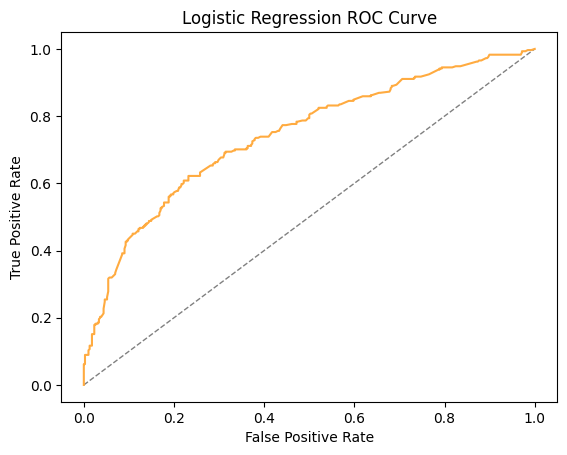

The total AUC is  0.7419049137350764


In [24]:
# Fit logisti regression
clf2 = LogisticRegression(solver='newton-cg')
clf2.fit(X_train,y_train)

# Predict y probability 
y_pred = clf2.predict_proba(X_test) 
y_pred_prob = y_pred[:,1]

# ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed', linewidth = 1)
plt.plot(fpr, tpr, label='Logistic Regression', color= '#ffab40')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

#AUC
print('The total AUC is ', metrics.roc_auc_score(y_test, y_pred_prob))

Although we used the same sample A for our ROC, the AUC is different from Northpointe (AUC=0.71).

## The Washington Post 1 Analysis

The Washington Post 1 goes beyond the claims from Northpointe and ProPublica, and gives a more comprehensive explanation.

Basically, they claim that an algorithm can't be fair on both ways:
- Northpointe's definition of fairness: in each risk score, both groups have the same proportion of recidivism.
- ProPublica definition of fairnes: among defendants who did not reoffend, the proportion of blacks and whites that were classified as low risk should have been the same. As we shown, black defendants are more likely to be classified as High risk although they later wouldn't reoffend.


In [25]:
def calibration_curve(df):
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

In [30]:
# Create Datafram with only african-americans
raw_data = load_raw_df()
df_black = raw_data.loc[raw_data['race'].isin(["African-American"])]
df_black.shape

(3696, 53)

Washington Post shows the Northpointe's definition of fairnes with the following graphic, which shows the recidivism rate by risk score and race. White and black defendants with the same risk score are roughly equally likely to reoffend.

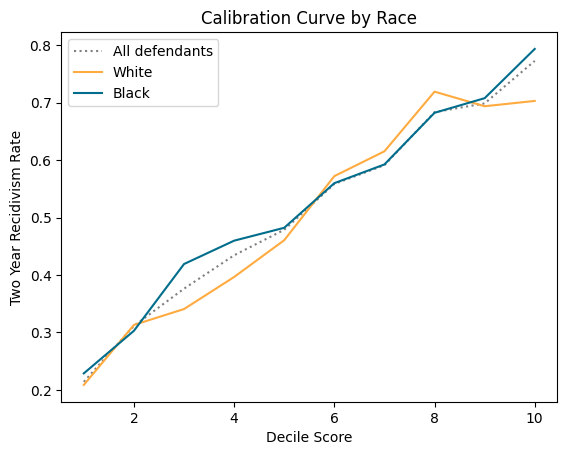

In [31]:
# for all data in the dataset
cal_all = calibration_curve(raw_data)
cal_all.plot(linestyle = 'dotted', 
              color = 'gray',
              label= "All defendants")

# White Defendants
cal_white = calibration_curve(raw_data[raw_data['race'] == "Caucasian"])
cal_white.plot(
    color = "#ffab40",
    label = "White")

# Black Defendants
cal_black = calibration_curve(raw_data[raw_data['race'] == "African-American"])
cal_black.plot(
    color = "#016d8c",
    label='Black')

# Add title and label
plt.title("Calibration Curve by Race")
plt.xlabel("Decile Score")
plt.ylabel("Two Year Recidivism Rate")
plt.legend()

In [32]:
# Create Datafram with only african-americans
df_black = raw_data.loc[raw_data['race'].isin(["African-American"])]

# Create dataframe with only caucasians
df_white = raw_data.loc[raw_data['race'].isin(["Caucasian"])]

In this section, we will perform the following steps to analyze the data per race:

* Relabel the score text as before, but instead of using numerical values, we will use descriptive labels.

* Divide the dataframe into two groups: those who recidivated and those who did not.

In [33]:
# Per race:
# Relabel the score text as before but not with numerical
# Devide dataframe in recidivated and non-recidivated
df_white['score_text'] = raw_data['score_text'].replace(['Medium'], 'Medium/High').replace(['High'], 'Medium/High')
df_white_recid = df_white.loc[df_white['is_recid'].isin([1])]
df_white_nonrecid = df_white.loc[df_white['is_recid'].isin([0])]

df_black['score_text'] = raw_data['score_text'].replace(['Medium'], 'Medium/High').replace(['High'], 'Medium/High')
df_black_recid = df_black.loc[df_black['is_recid'].isin([1])]
df_black_nonrecid = df_black.loc[df_black['is_recid'].isin([0])]

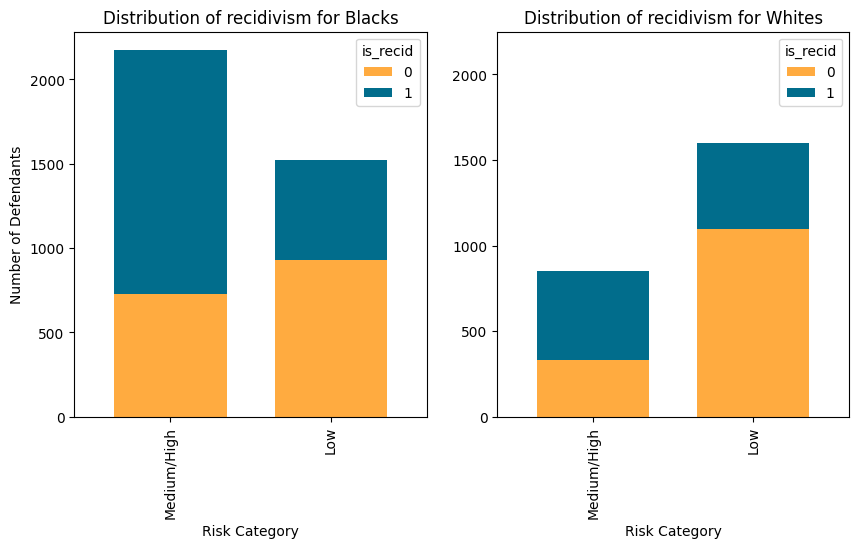

In [34]:
# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot first dataframe
df_plot = df_black.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Blacks',
    color=["#ffab40","#016d8c"],
    ax=ax1)
ax1.set_xlabel("Risk Category")
ax1.set_ylabel("Number of Defendants")
ax1.invert_xaxis()
plt.ylim([0, 2250])
plt.yticks([0, 500, 1000, 1500, 2000])

# Plot second dataframe
df_plot = df_white.groupby(['is_recid', 'score_text']).size().reset_index().pivot(columns='is_recid', index='score_text', values=0)
df_plot.plot(
    kind='bar', 
    stacked=True,
    width=0.7,
    title='Distribution of recidivism for Whites',
    color=["#ffab40","#016d8c"],
    ax=ax2)
ax2.set_xlabel("Risk Category")
ax2.set_ylabel("")
ax2.invert_xaxis()
plt.ylim([0, 2250])
plt.yticks([0, 500, 1000, 1500, 2000])

# Show plot
plt.show()

Finally, on their article they show the previous chart to visualize two things:
- The proportion of defendants who reoffend is the same for black and white people.
- The recidivism base rate for black defendants is higher than for white defendants.

With this, they explain that innevitably a greater amount of black defendant will be classified as high risk, and with that more black defendant will also be missclassified as high risk.

In relation to what Northpointe said, if the prevalence (recidivism base rate) for both groups is different, then is not possible for both errors (model and population) to be fair.

Northpointe has "fair", meaning similar, population errors, and therefore the FPR (model error) will be higher for black people.